# GluonTS - Transfer Learning Approach (monthly) - 1/2

- Two datasets: A and B
- Dataset A: Dataset subsetted by frequency, i.e. `m4_monthly`
- Dataset B: Dataset subsetted by frequency and by domain, i.e. `m4_monthly_industry`
- Network A: Trained on dataset A
- Network B: Trained on dataset B
- Both networks are evaluated on dataset B. 

- Adjust epochs to account for different size of the datasets

Goal: Check TZ1: "Does the network learn from time series of the same domain or is it helpful to use time series from other domains?"

- Both networks are trained for ten trials (deepar) or three trials (deepstate)

Note that there are already results where a network is trained on `m4_frequency_domain` and evaluated on the same network.

In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.8MB/s  eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 11.6MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 25.6MB/s ta 0:00:01
    100% |████████████████████████████████| 7.3MB 5.9MB/s eta 0:00:011
    100% |████████████████████████████████| 10.4MB 4.6MB/s  eta 0:00:01
    100% |████████████████████████████████| 194kB 66.2MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 92kB 54.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1f/fd/3a/f29866dc23dada18f25e9837477c82bbd7952aeef86fa46f11
Successfully built ujson holidays
  Found existing installation: python-dateut

## Imports



In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [4]:
dataset = get_dataset("m4_weekly", regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.


### mv the data

Before moving on: Move the respective data according the required folder structure. In AWS:

- `mv [dataname] ../../.mxnet/gluon-ts/datasets/`

In [5]:
dataname_a = "m4_monthly_atm"
dataset_a = get_dataset(dataname_a, regenerate=False)
len(dataset_a.train)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_atm.


48000

In [6]:
dataname_b = "m4_monthly_industry"
dataset_b = get_dataset(dataname_b, regenerate=False)
len(dataset_b.train)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.


10017

## Check the datasets 

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 48000
length test: 48000

start:
 1750-01-31 00:00:00
target:
 [8000. 8350. 8570. 7700. 7080. 6520. 6070. 6650. 6830. 5710.]
feat_static_cat:
 [1]


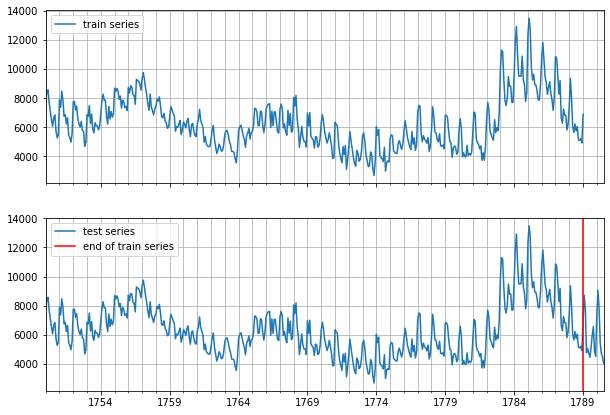

In [7]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset B

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 10017
length test: 10017

start:
 1750-01-31 00:00:00
target:
 [8370. 8430. 7880. 8160. 8290. 8000. 8240. 7840. 8040. 7930.]
feat_static_cat:
 [1]


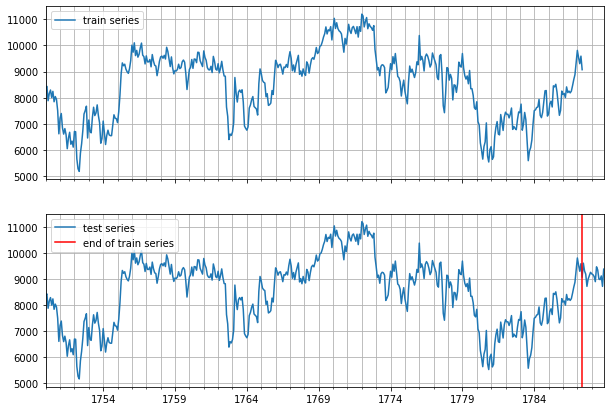

In [8]:
train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [9]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: False
Length test test: False
Frequency test: True


## Modeling: DeepAR

In [10]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [11]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=<MetaData freq='M' target=None feat_static_cat=[<CategoricalFeatureInfo name='feat_static_cat' cardinality='48000'>] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=18>, train=<gluonts.dataset.common.FileDataset object at 0x000001D01A09BA20>, test=<gluonts.dataset.common.FileDataset object at 0x000001D01A09BD68>)

 TrainDatasets(metadata=<MetaData freq='M' target=None feat_static_cat=[<CategoricalFeatureInfo name='feat_static_cat' cardinality='10017'>] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=18>, train=<gluonts.dataset.common.FileDataset object at 0x000001D01A09BE10>, test=<gluonts.dataset.common.FileDataset object at 0x000001D01A0B7278>)


In [12]:
print(dataname_a)
print(dataname_b)

m4_monthly_atm
m4_monthly_industry


In [13]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
#     assert ( len(dataset_a.train)==len(dataset_b.train) )
#     assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )
    
#     estimator = DeepAREstimator(
#         trainer=trainer,
#         cardinality= [
#             feat_static_cat.cardinality 
#             for feat_static_cat in dataset_a.metadata.feat_static_cat
#         ],
#         context_length=dataset_a.metadata.prediction_length,
#         prediction_length=dataset_a.metadata.prediction_length,
#         freq=dataset_a.metadata.freq,
#         use_feat_static_cat=True
#     )
    
    # predictor trained on dataset_a, evaluated on dataset_b
    predictor_a=estimator.train(training_data=dataset_a.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_b.test, predictor=predictor_a, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_b.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_a
    output["eval data"]=dataname_b
    
    df=pd.DataFrame([output])

    return df

    

## Subsets

In [14]:
print(dataname_a)
print(dataname_b)

m4_monthly_atm
m4_monthly_industry


## Study 1: `m4_monthly` vs. `m4_monthly_industry` trained network

### Run I.: Training: A, Eval: B

- 10 trials training a network on dataset a and evaluating network on data a

In [15]:
# results = pd.DataFrame()

# for i in range(42,45):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_industry", seed=i, epochs=400, num_batches=200)
#     pprint(df)
#     results = results.append(df)
    
# results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_industry", seed=i, epochs=750, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 31.51it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 3.175 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.343221
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.96it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[1] Elapsed time 2.946 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.623668
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.87it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[2] Elapsed time 3.139 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.966132
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.34it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[3] Elapsed time 2.831 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.876541
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.57it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.21it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 2.764 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.018014
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.40it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[38] Elapsed time 2.909 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.879292
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.17it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[39] Elapsed time 3.110 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.470131
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.94it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[40] Elapsed time 2.784 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.181063
INFO:root:Epoch[41] Learning rate is 0.00025
100%|█████████

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[73] Elapsed time 2.988 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.184395
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.98it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[74] Elapsed time 2.781 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.383841
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.07it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[75] Elapsed time 2.774 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.065597
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[76] Elapsed time 2.973 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.272950
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.96it/s, avg_epoch_loss=6.4]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 2.868 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.600730
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.58it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[111] Elapsed time 2.893 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.173856
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.61it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[112] Elapsed time 2.890 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.797600
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.21it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[113] Elapsed time 2.924 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.023549
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.55it/s, avg_epoch_lo

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.112952
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.50it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[147] Elapsed time 3.512 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.714579
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 3.099 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.447885
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.50it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[149] Elapsed time 2.900 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.356112
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.48it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[150] Elapsed time 3.080 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.952841
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.11it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[220] Elapsed time 2.850 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.712535
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.73it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[221] Elapsed time 3.153 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.135225
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.55it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[222] Elapsed time 2.815 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.279786
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.12it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[223] Elapsed time 2.770 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.715267
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.86it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.672818
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.59it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[257] Elapsed time 2.983 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.089581
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.42it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[258] Elapsed time 3.184 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.502381
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.31it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[259] Elapsed time 2.917 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.111120
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.21it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[260] Elapsed time 2.764 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.386632
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.31it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[330] Elapsed time 3.004 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.287958
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.60it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[331] Elapsed time 2.811 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.979818
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.77it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[332] Elapsed time 2.878 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.980926
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[333] Elapsed time 3.031 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.104649
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.05it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.733263
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.22it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[367] Elapsed time 2.841 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.958846
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.20it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[368] Elapsed time 3.014 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.311857
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.32it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[369] Elapsed time 2.915 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.895006
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.22it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[370] Elapsed time 3.012 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.920865
INFO:root:Epoch[371] Learning rate is 5e-05


INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.16it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[440] Elapsed time 2.692 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.076672
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.90it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[441] Elapsed time 2.787 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.635868
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.78it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[442] Elapsed time 2.962 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.799324
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.71it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[443] Elapsed time 2.883 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.440143
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.07it/s, avg_epoch_l

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.890114
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.51it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[477] Elapsed time 2.668 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.785860
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.24it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[478] Elapsed time 2.687 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.223236
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.32it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[479] Elapsed time 3.004 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.871221
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.59it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[480] Elapsed time 3.170 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.660312
INFO:root:Epoch[481] Learning rate is 5e-05

INFO:root:Epoch[550] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.48it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[550] Elapsed time 2.902 seconds
INFO:root:Epoch[550] Evaluation metric 'epoch_loss'=6.898525
INFO:root:Epoch[551] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.62it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[551] Elapsed time 2.976 seconds
INFO:root:Epoch[551] Evaluation metric 'epoch_loss'=6.816080
INFO:root:Epoch[552] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[552] Elapsed time 3.040 seconds
INFO:root:Epoch[552] Evaluation metric 'epoch_loss'=5.774205
INFO:root:Epoch[553] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.46it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[553] Elapsed time 2.748 seconds
INFO:root:Epoch[553] Evaluation metric 'epoch_loss'=7.205149
INFO:root:Epoch[554] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_l

INFO:root:Epoch[586] Evaluation metric 'epoch_loss'=6.725762
INFO:root:Epoch[587] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.61it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[587] Elapsed time 3.068 seconds
INFO:root:Epoch[587] Evaluation metric 'epoch_loss'=6.811150
INFO:root:Epoch[588] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.99it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[588] Elapsed time 2.705 seconds
INFO:root:Epoch[588] Evaluation metric 'epoch_loss'=5.587201
INFO:root:Epoch[589] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.20it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[589] Elapsed time 2.764 seconds
INFO:root:Epoch[589] Evaluation metric 'epoch_loss'=6.456854
INFO:root:Epoch[590] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.81it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[590] Elapsed time 2.874 seconds
INFO:root:Epoch[590] Evaluation metric 'epoch_loss'=5.888295
INFO:root:Epoch[591] Learning rate is 5e-05

INFO:root:Epoch[660] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.41it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[660] Elapsed time 2.826 seconds
INFO:root:Epoch[660] Evaluation metric 'epoch_loss'=5.413075
INFO:root:Epoch[661] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.46it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[661] Elapsed time 2.990 seconds
INFO:root:Epoch[661] Evaluation metric 'epoch_loss'=6.890797
INFO:root:Epoch[662] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.76it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[662] Elapsed time 3.054 seconds
INFO:root:Epoch[662] Evaluation metric 'epoch_loss'=6.263258
INFO:root:Epoch[663] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.87it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[663] Elapsed time 2.869 seconds
INFO:root:Epoch[663] Evaluation metric 'epoch_loss'=5.973815
INFO:root:Epoch[664] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.43it/s, avg_epoch_

INFO:root:Epoch[696] Evaluation metric 'epoch_loss'=6.610878
INFO:root:Epoch[697] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.34it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[697] Elapsed time 2.914 seconds
INFO:root:Epoch[697] Evaluation metric 'epoch_loss'=7.262786
INFO:root:Epoch[698] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.52it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[698] Elapsed time 2.740 seconds
INFO:root:Epoch[698] Evaluation metric 'epoch_loss'=5.661469
INFO:root:Epoch[699] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.86it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[699] Elapsed time 2.955 seconds
INFO:root:Epoch[699] Evaluation metric 'epoch_loss'=6.672141
INFO:root:Epoch[700] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.82it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[700] Elapsed time 3.145 seconds
INFO:root:Epoch[700] Evaluation metric 'epoch_loss'=6.961150
INFO:root:Epoch[701] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.137045  0.145004  22.947739            0.120742            0.082859   

   seed  epochs  num_batches      train data            eval data  
0    42     750          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 32.24it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 3.103 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.228455
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.77it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 2.878 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.628459
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.69it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 3.061 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.114693
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.10it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[3] Elapsed time 2.934 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.839976
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.71it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.06it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[37] Elapsed time 3.027 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.808802
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.37it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[38] Elapsed time 2.911 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.464351
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.41it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[39] Elapsed time 2.826 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.944855
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.40it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[40] Elapsed time 2.826 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.220884
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.42it/s, avg_epoch_loss=7.0

100%|██████████| 100/100 [00:02<00:00, 37.28it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[73] Elapsed time 2.685 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.317707
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 34.79it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[74] Elapsed time 2.876 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.501502
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 30.90it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[75] Elapsed time 3.238 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.057750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 35.62it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 2.809 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.723752
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 34.55it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[77] Elapsed time 2

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.68it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 2.728 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.602310
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.39it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[111] Elapsed time 2.676 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.176375
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.30it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[112] Elapsed time 3.004 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.076702
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.25it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[113] Elapsed time 3.202 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.084923
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.50it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.019261
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.38it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[147] Elapsed time 2.828 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.645034
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.89it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 2.712 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.457369
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.51it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[149] Elapsed time 2.986 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.472114
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.21it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[150] Elapsed time 2.925 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.757861
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.90it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[220] Elapsed time 3.138 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=7.060703
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.95it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[221] Elapsed time 3.232 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.015836
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.31it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[222] Elapsed time 2.756 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.047707
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.96it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[223] Elapsed time 2.710 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=7.148105
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.13it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.032613
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.47it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[257] Elapsed time 2.903 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.076933
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.61it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[258] Elapsed time 2.977 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.220458
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.77it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[259] Elapsed time 2.721 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.236310
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.26it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[260] Elapsed time 2.686 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.399914
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.27it/s, avg_epoch_loss=6]
INFO:root:Epoch[330] Elapsed time 3.007 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.004546
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.61it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[331] Elapsed time 2.810 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.128719
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.73it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[332] Elapsed time 2.966 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.115184
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.76it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[333] Elapsed time 3.054 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.959840
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.49it/s, avg_epoch_los

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.682224
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[367] Elapsed time 2.880 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=7.581530
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.03it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[368] Elapsed time 2.940 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.799614
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.90it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[369] Elapsed time 2.787 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.068367
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.38it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[370] Elapsed time 2.998 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.954720
INFO:root:Epoch[371] Learning rate is 5e-05


INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.57it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[440] Elapsed time 2.894 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.050251
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.55it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[441] Elapsed time 2.982 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.590863
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.46it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[442] Elapsed time 2.990 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.634521
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.66it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[443] Elapsed time 2.887 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.431982
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.18it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.706719
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.94it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[477] Elapsed time 2.948 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.965525
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.35it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[478] Elapsed time 2.752 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.068163
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.44it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[479] Elapsed time 2.905 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.915225
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.48it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[480] Elapsed time 2.819 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.336552
INFO:root:Epoch[481] Learning rate is 5e-05

INFO:root:Epoch[550] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.26it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[550] Elapsed time 2.920 seconds
INFO:root:Epoch[550] Evaluation metric 'epoch_loss'=6.861017
INFO:root:Epoch[551] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.74it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[551] Elapsed time 2.880 seconds
INFO:root:Epoch[551] Evaluation metric 'epoch_loss'=6.501278
INFO:root:Epoch[552] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.17it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[552] Elapsed time 2.845 seconds
INFO:root:Epoch[552] Evaluation metric 'epoch_loss'=6.055001
INFO:root:Epoch[553] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.32it/s, avg_epoch_loss=7]
INFO:root:Epoch[553] Elapsed time 2.915 seconds
INFO:root:Epoch[553] Evaluation metric 'epoch_loss'=6.998236
INFO:root:Epoch[554] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_loss

INFO:root:Epoch[586] Evaluation metric 'epoch_loss'=6.935783
INFO:root:Epoch[587] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.27it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[587] Elapsed time 3.200 seconds
INFO:root:Epoch[587] Evaluation metric 'epoch_loss'=6.486302
INFO:root:Epoch[588] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.43it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[588] Elapsed time 2.993 seconds
INFO:root:Epoch[588] Evaluation metric 'epoch_loss'=5.762845
INFO:root:Epoch[589] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.60it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[589] Elapsed time 2.891 seconds
INFO:root:Epoch[589] Evaluation metric 'epoch_loss'=6.347494
INFO:root:Epoch[590] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.80it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[590] Elapsed time 2.795 seconds
INFO:root:Epoch[590] Evaluation metric 'epoch_loss'=5.911299
INFO:root:Epoch[591] Learning rate is 5e-05

INFO:root:Epoch[660] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.33it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[660] Elapsed time 2.917 seconds
INFO:root:Epoch[660] Evaluation metric 'epoch_loss'=5.237025
INFO:root:Epoch[661] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.17it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[661] Elapsed time 3.020 seconds
INFO:root:Epoch[661] Evaluation metric 'epoch_loss'=6.560368
INFO:root:Epoch[662] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.93it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[662] Elapsed time 3.134 seconds
INFO:root:Epoch[662] Evaluation metric 'epoch_loss'=6.888774
INFO:root:Epoch[663] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.96it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[663] Elapsed time 2.783 seconds
INFO:root:Epoch[663] Evaluation metric 'epoch_loss'=5.484174
INFO:root:Epoch[664] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.96it/s, avg_epoch_

INFO:root:Epoch[696] Evaluation metric 'epoch_loss'=5.834636
INFO:root:Epoch[697] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.61it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[697] Elapsed time 3.165 seconds
INFO:root:Epoch[697] Evaluation metric 'epoch_loss'=7.513046
INFO:root:Epoch[698] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.73it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[698] Elapsed time 2.881 seconds
INFO:root:Epoch[698] Evaluation metric 'epoch_loss'=5.941956
INFO:root:Epoch[699] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.98it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[699] Elapsed time 3.038 seconds
INFO:root:Epoch[699] Evaluation metric 'epoch_loss'=6.073724
INFO:root:Epoch[700] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.46it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[700] Elapsed time 2.904 seconds
INFO:root:Epoch[700] Evaluation metric 'epoch_loss'=6.802775
INFO:root:Epoch[701] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.159536  0.145769  20.981775            0.121481             0.07356   

   seed  epochs  num_batches      train data            eval data  
0    43     750          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 31.98it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 3.129 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.398375
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.43it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 2.906 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.594616
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.79it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[2] Elapsed time 3.147 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.921513
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.52it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 2.986 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.914622
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.66it/s, avg_epoch_loss=7

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.602819
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.18it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[37] Elapsed time 3.109 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.079047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.48it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 2.821 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.197690
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.80it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[39] Elapsed time 2.960 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.366086
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.67it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 2.886 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.303811
INFO:root:Epoch[41] Learning rate is 0.00025
100%|

INFO:root:Loading parameters from best epoch (52)
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.93it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[73] Elapsed time 2.950 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.236422
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.07it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[74] Elapsed time 2.857 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.623828
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.06it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[75] Elapsed time 3.027 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.202576
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.58it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[76] Elapsed time 2.979 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.164812
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.19it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 2.765 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.608541
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.57it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[111] Elapsed time 2.813 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.276086
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.04it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[112] Elapsed time 2.776 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.188950
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.15it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[113] Elapsed time 2.930 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.010631
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.47it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.147996
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 2.989 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.924309
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.44it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[148] Elapsed time 2.992 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.238040
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.90it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[149] Elapsed time 2.787 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.350010
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.39it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[150] Elapsed time 2.997 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.103930
INFO:root:Epoch[151] Learning rate is 5e-05


INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[220] Elapsed time 3.000 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.244596
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.36it/s, avg_epoch_loss=7]
INFO:root:Epoch[221] Elapsed time 2.830 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.004610
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.73it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[222] Elapsed time 3.057 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.834183
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.62it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[223] Elapsed time 2.975 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.163014
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.66it/s, avg_epoch_los

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.586564
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[257] Elapsed time 2.988 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.861556
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.51it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[258] Elapsed time 3.280 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=7.016275
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.69it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[259] Elapsed time 2.727 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.755165
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.24it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[260] Elapsed time 2.687 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.529849
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.30it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[330] Elapsed time 2.917 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.977310
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.91it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[331] Elapsed time 2.787 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.429252
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.36it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[332] Elapsed time 2.830 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.011499
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.19it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[333] Elapsed time 3.108 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.871574
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.09it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.096650
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.92it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[367] Elapsed time 2.711 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.816335
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.23it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[368] Elapsed time 2.840 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.909639
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.43it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[369] Elapsed time 2.824 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.454206
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.71it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[370] Elapsed time 2.882 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.168462
INFO:root:Epoch[371] Learning rate is 5e-05

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.26it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[440] Elapsed time 2.759 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.511915
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.19it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[441] Elapsed time 2.765 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.078911
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.43it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[442] Elapsed time 2.906 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.712927
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.44it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[443] Elapsed time 2.823 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.657108
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.44it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=7.034149
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.40it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[477] Elapsed time 2.996 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.764762
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.08it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[478] Elapsed time 2.776 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.047529
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.42it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[479] Elapsed time 2.994 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.240681
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.00it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[480] Elapsed time 3.032 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.962072
INFO:root:Epoch[481] Learning rate is 5e-05

INFO:root:Epoch[550] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.32it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[550] Elapsed time 2.833 seconds
INFO:root:Epoch[550] Evaluation metric 'epoch_loss'=6.660104
INFO:root:Epoch[551] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.24it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[551] Elapsed time 3.010 seconds
INFO:root:Epoch[551] Evaluation metric 'epoch_loss'=6.932199
INFO:root:Epoch[552] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.05it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[552] Elapsed time 3.029 seconds
INFO:root:Epoch[552] Evaluation metric 'epoch_loss'=6.341745
INFO:root:Epoch[553] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.97it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[553] Elapsed time 2.946 seconds
INFO:root:Epoch[553] Evaluation metric 'epoch_loss'=6.307794
INFO:root:Epoch[554] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.92it/s, avg_epoch_

INFO:root:Epoch[586] Evaluation metric 'epoch_loss'=5.114230
INFO:root:Epoch[587] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.08it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[587] Elapsed time 2.773 seconds
INFO:root:Epoch[587] Evaluation metric 'epoch_loss'=6.987943
INFO:root:Epoch[588] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.17it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[588] Elapsed time 3.110 seconds
INFO:root:Epoch[588] Evaluation metric 'epoch_loss'=6.718153
INFO:root:Epoch[589] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.30it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[589] Elapsed time 2.917 seconds
INFO:root:Epoch[589] Evaluation metric 'epoch_loss'=5.744973
INFO:root:Epoch[590] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.48it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[590] Elapsed time 2.902 seconds
INFO:root:Epoch[590] Evaluation metric 'epoch_loss'=6.425268
INFO:root:Epoch[591] Learning rate is 5e-05

In [25]:
results

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.074303,0.142926,21.429599,0.119802,0.090300,42,157,100,m4_monthly_industry,m4_monthly_industry
0,1.345366,0.148374,23.984432,0.129041,0.103893,43,157,100,m4_monthly_industry,m4_monthly_industry


In [15]:
results = pd.DataFrame()

for i in range(44,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_industry", seed=i, epochs=750, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

Next seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_atm.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.53it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 8.143 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.398375
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.64it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 7.920 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.594619
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.79it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[2] Elapsed time 10.220 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.916686
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 12.53it/s, avg_epoch_lo

INFO:root:Epoch[35] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 16.42it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[35] Elapsed time 6.089 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.488613
INFO:root:Epoch[36] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.74it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[36] Elapsed time 6.801 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.603511
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 16.77it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[37] Elapsed time 5.968 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.079847
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 15.45it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[38] Elapsed time 6.477 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.207240
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:08<00:00, 11.66it/s, avg_epoch_loss

100%|██████████| 100/100 [00:06<00:00, 16.05it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[71] Elapsed time 6.235 seconds
INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=7.142589
INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:06<00:00, 15.49it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[72] Elapsed time 6.455 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=7.018287
INFO:root:Loading parameters from best epoch (52)
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.38it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[73] Elapsed time 6.124 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.238558
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.35it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[74] Elapsed time 6.137 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.624525
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 12.67it/s, avg_epoch_los

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=6.972549
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.16it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[108] Elapsed time 6.597 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=7.195063
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.45it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[109] Elapsed time 6.084 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.959970
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.84it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 5.939 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.609607
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.63it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[111] Elapsed time 6.014 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.279194
INFO:root:Epoch[112] Learning rate is 5e-05


100%|██████████| 100/100 [00:06<00:00, 16.31it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[144] Elapsed time 6.138 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=6.461205
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.00it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[145] Elapsed time 6.251 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.310331
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.41it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[146] Elapsed time 6.099 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.149182
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.72it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[147] Elapsed time 6.381 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.927485
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.34it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[148] Elapsed time

INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=7.099646
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.28it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[181] Elapsed time 6.141 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=5.844111
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.75it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[182] Elapsed time 6.372 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.745404
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.09it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[183] Elapsed time 6.633 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=7.149304
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.48it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[184] Elapsed time 6.069 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.794843
INFO:root:Epoch[185] Learning rate is 5e-05

100%|██████████| 100/100 [00:06<00:00, 14.96it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[217] Elapsed time 6.703 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=5.867009
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.88it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[218] Elapsed time 8.421 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=7.930124
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.21it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[219] Elapsed time 8.197 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.413329
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 11.04it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[220] Elapsed time 9.063 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.251481
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.65it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[221] Elapsed time

INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=6.249914
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.85it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[254] Elapsed time 5.938 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=7.404630
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.70it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[255] Elapsed time 6.372 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=7.009990
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.61it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[256] Elapsed time 6.025 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.601920
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.10it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[257] Elapsed time 6.217 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.871221
INFO:root:Epoch[258] Learning rate is 5e-05
1

100%|██████████| 100/100 [00:05<00:00, 16.86it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[290] Elapsed time 5.948 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=6.557514
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.84it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[291] Elapsed time 5.955 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=6.145721
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.89it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[292] Elapsed time 5.922 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.990352
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.99it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[293] Elapsed time 6.252 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=7.827890
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.39it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[294] Elapsed time

INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=7.025001
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.74it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[327] Elapsed time 6.368 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=6.729200
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.59it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[328] Elapsed time 6.044 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=6.198861
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.11it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[329] Elapsed time 5.860 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=7.217919
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.46it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[330] Elapsed time 6.469 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.984538
INFO:root:Epoch[331] Learning rate is 5e-05


100%|██████████| 100/100 [00:06<00:00, 15.28it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[363] Elapsed time 6.545 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=7.010623
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.90it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[364] Elapsed time 6.304 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=5.646091
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.33it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[365] Elapsed time 6.156 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=6.527266
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.74it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[366] Elapsed time 5.973 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.104277
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.97it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[367] Elapsed time 

INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=6.705944
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.18it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[400] Elapsed time 6.197 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=6.114978
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.73it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[401] Elapsed time 6.357 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=7.041970
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.26it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[402] Elapsed time 6.553 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=6.846296
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.37it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[403] Elapsed time 6.125 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.896327
INFO:root:Epoch[404] Learning rate is 5e-05


100%|██████████| 100/100 [00:06<00:00, 15.86it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[436] Elapsed time 6.304 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=5.613035
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.25it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[437] Elapsed time 6.153 seconds
INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=6.508726
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.21it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[438] Elapsed time 6.574 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=6.965732
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.97it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[439] Elapsed time 5.908 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.668228
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.53it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[440] Elapsed time

INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=5.822645
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.74it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[473] Elapsed time 6.352 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=7.825200
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.26it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[474] Elapsed time 6.151 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=6.366084
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.41it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[475] Elapsed time 6.094 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=6.133975
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.11it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[476] Elapsed time 6.207 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=7.044680
INFO:root:Epoch[477] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 16.67it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[509] Elapsed time 5.998 seconds
INFO:root:Epoch[509] Evaluation metric 'epoch_loss'=7.264741
INFO:root:Epoch[510] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.47it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[510] Elapsed time 6.463 seconds
INFO:root:Epoch[510] Evaluation metric 'epoch_loss'=6.906918
INFO:root:Epoch[511] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.50it/s, avg_epoch_loss=5.23]
INFO:root:Epoch[511] Elapsed time 6.077 seconds
INFO:root:Epoch[511] Evaluation metric 'epoch_loss'=5.233112
INFO:root:Epoch[512] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.07it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[512] Elapsed time 6.240 seconds
INFO:root:Epoch[512] Evaluation metric 'epoch_loss'=7.009902
INFO:root:Epoch[513] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.15it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[513] Elapsed time

INFO:root:Epoch[545] Evaluation metric 'epoch_loss'=6.371349
INFO:root:Epoch[546] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.57it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[546] Elapsed time 6.034 seconds
INFO:root:Epoch[546] Evaluation metric 'epoch_loss'=5.870878
INFO:root:Epoch[547] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.57it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[547] Elapsed time 6.034 seconds
INFO:root:Epoch[547] Evaluation metric 'epoch_loss'=6.478336
INFO:root:Epoch[548] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.71it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[548] Elapsed time 6.364 seconds
INFO:root:Epoch[548] Evaluation metric 'epoch_loss'=7.495306
INFO:root:Epoch[549] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.37it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[549] Elapsed time 6.108 seconds
INFO:root:Epoch[549] Evaluation metric 'epoch_loss'=5.870349
INFO:root:Epoch[550] Learning rate is 5e-05


100%|██████████| 100/100 [00:06<00:00, 15.94it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[582] Elapsed time 6.273 seconds
INFO:root:Epoch[582] Evaluation metric 'epoch_loss'=6.507897
INFO:root:Epoch[583] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.41it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[583] Elapsed time 6.093 seconds
INFO:root:Epoch[583] Evaluation metric 'epoch_loss'=6.245322
INFO:root:Epoch[584] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.41it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[584] Elapsed time 6.109 seconds
INFO:root:Epoch[584] Evaluation metric 'epoch_loss'=7.198712
INFO:root:Epoch[585] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.58it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[585] Elapsed time 6.436 seconds
INFO:root:Epoch[585] Evaluation metric 'epoch_loss'=6.824929
INFO:root:Epoch[586] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.45it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[586] Elapsed time 

INFO:root:Epoch[618] Evaluation metric 'epoch_loss'=6.731829
INFO:root:Epoch[619] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.99it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[619] Elapsed time 5.888 seconds
INFO:root:Epoch[619] Evaluation metric 'epoch_loss'=5.735421
INFO:root:Epoch[620] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.99it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[620] Elapsed time 5.886 seconds
INFO:root:Epoch[620] Evaluation metric 'epoch_loss'=6.418643
INFO:root:Epoch[621] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.96it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[621] Elapsed time 5.897 seconds
INFO:root:Epoch[621] Evaluation metric 'epoch_loss'=5.957155
INFO:root:Epoch[622] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.71it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[622] Elapsed time 5.984 seconds
INFO:root:Epoch[622] Evaluation metric 'epoch_loss'=6.209972
INFO:root:Epoch[623] Learning rate is 5e-05

100%|██████████| 100/100 [00:06<00:00, 14.33it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[655] Elapsed time 6.980 seconds
INFO:root:Epoch[655] Evaluation metric 'epoch_loss'=6.604142
INFO:root:Epoch[656] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.39it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[656] Elapsed time 8.072 seconds
INFO:root:Epoch[656] Evaluation metric 'epoch_loss'=6.920037
INFO:root:Epoch[657] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.42it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[657] Elapsed time 6.092 seconds
INFO:root:Epoch[657] Evaluation metric 'epoch_loss'=6.312807
INFO:root:Epoch[658] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.86it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[658] Elapsed time 5.931 seconds
INFO:root:Epoch[658] Evaluation metric 'epoch_loss'=6.195196
INFO:root:Epoch[659] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.02it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[659] Elapsed time 5

INFO:root:Epoch[691] Evaluation metric 'epoch_loss'=5.111629
INFO:root:Epoch[692] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.31it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[692] Elapsed time 6.130 seconds
INFO:root:Epoch[692] Evaluation metric 'epoch_loss'=6.833840
INFO:root:Epoch[693] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.93it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[693] Elapsed time 7.195 seconds
INFO:root:Epoch[693] Evaluation metric 'epoch_loss'=6.790694
INFO:root:Epoch[694] Learning rate is 5e-05
100%|██████████| 100/100 [00:07<00:00, 13.76it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[694] Elapsed time 7.267 seconds
INFO:root:Epoch[694] Evaluation metric 'epoch_loss'=5.640713
INFO:root:Epoch[695] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.99it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[695] Elapsed time 5.901 seconds
INFO:root:Epoch[695] Evaluation metric 'epoch_loss'=6.421598
INFO:root:Epoch[696] Learning rate is 5e-05

100%|██████████| 100/100 [00:06<00:00, 16.12it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[728] Elapsed time 6.202 seconds
INFO:root:Epoch[728] Evaluation metric 'epoch_loss'=7.558084
INFO:root:Epoch[729] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.27it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[729] Elapsed time 6.146 seconds
INFO:root:Epoch[729] Evaluation metric 'epoch_loss'=6.428312
INFO:root:Epoch[730] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.16it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[730] Elapsed time 6.189 seconds
INFO:root:Epoch[730] Evaluation metric 'epoch_loss'=6.016845
INFO:root:Epoch[731] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.80it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[731] Elapsed time 6.347 seconds
INFO:root:Epoch[731] Evaluation metric 'epoch_loss'=6.928026
INFO:root:Epoch[732] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 12.28it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[732] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.134576  0.145763  21.622427            0.122441            0.079848   

   seed  epochs  num_batches      train data            eval data  
0    44     750          100  m4_monthly_atm  m4_monthly_industry  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.134576,0.145763,21.622427,0.122441,0.079848,44,750,100,m4_monthly_atm,m4_monthly_industry


### Run II.: Training: B, Eval: B

- 10 trials of training a network on dataset a and evaluating it on dataset b.

In [16]:
# results = pd.DataFrame()

# for i in range(48,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_industry", dataname_b="m4_monthly_industry", seed=i, epochs=200, num_batches=100)
#     pprint(df)
#     results = results.append(df)
    
# results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_industry", dataname_b="m4_monthly_industry", seed=i, epochs=157, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

Next seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.57it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[0] Elapsed time 6.879 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.199596
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.31it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[1] Elapsed time 6.549 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.904699
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.98it/s, avg_epoch_loss=7]
INFO:root:Epoch[2] Elapsed time 6.256 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.004547
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 16.24it/s, avg_epoch_lo

100%|██████████| 100/100 [00:06<00:00, 15.26it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[35] Elapsed time 6.567 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.533503
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 16.21it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[36] Elapsed time 6.171 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.251977
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 16.43it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[37] Elapsed time 6.106 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.225429
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 15.58it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[38] Elapsed time 6.419 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.611764
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 15.62it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[39] Elapsed time 6.403 se

100%|██████████| 100/100 [00:06<00:00, 15.79it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[71] Elapsed time 6.348 seconds
INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=5.818476
INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:06<00:00, 15.66it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[72] Elapsed time 6.400 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=7.339441
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:06<00:00, 15.05it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[73] Elapsed time 6.644 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.157764
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:06<00:00, 16.35it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[74] Elapsed time 6.115 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.025399
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:06<00:00, 16.06it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[75] Elapsed time 

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=7.461091
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.46it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[108] Elapsed time 6.485 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=6.141799
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.20it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[109] Elapsed time 6.188 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.663850
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.47it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[110] Elapsed time 6.466 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.570714
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 16.23it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[111] Elapsed time 6.160 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.147174
INFO:root:Epoch[112] Learning rate is 5e-05

100%|██████████| 100/100 [00:08<00:00, 12.05it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[144] Elapsed time 8.298 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=7.987350
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:24<00:00,  4.07it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[145] Elapsed time 24.567 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.315974
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.71it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[146] Elapsed time 8.540 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.879709
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:17<00:00,  5.71it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[147] Elapsed time 17.522 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.800514
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.13it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[148] Elapsed tim

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.099305  0.143207  19.986846            0.120834            0.088869   

   seed  epochs  num_batches           train data            eval data  
0    42     157          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.48it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[0] Elapsed time 8.015 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.119221
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.41it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 7.456 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887033
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.63it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[2] Elapsed time 6.835 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.903028
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.23it/s, avg_epoc

100%|██████████| 100/100 [00:23<00:00,  4.29it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[35] Elapsed time 23.330 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.468595
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:20<00:00,  4.76it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[36] Elapsed time 21.018 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.123931
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:21<00:00,  4.69it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[37] Elapsed time 21.316 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.330769
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:24<00:00,  4.14it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[38] Elapsed time 24.165 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.598961
INFO:root:Loading parameters from best epoch (18)
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:21<00:00,  4.66it/s, avg_epoc

## `m4_monthly_demographic`

## Study 2: `m4_monthly_atm` vs. `m4_monthly_demographic` trained network

### Run I.: Training: A, Eval: B

- 10 trials training a network on dataset a and evaluating network on data a

In [17]:
# results = pd.DataFrame()

# for i in range(42,45):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_demographic", seed=i, epochs=500, num_batches=100)
#     pprint(df)
#     results = results.append(df)
    
# results

### Run II.: Training: B, Eval: B

- 10 trials of training a network on dataset a and evaluating it on dataset b.

In [18]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_demographic", dataname_b="m4_monthly_demographic", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

# Study 3: `m4_monthly_finance`

## Run I - Training: A, Eval: B

In [19]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_finance", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results

## Run II - Training: B, Eval: B

In [ ]:
# results = pd.DataFrame()

# for i in range(42,52):
#     print("Next seed:", i)
#     df = deepar_train_eval(dataname_a="m4_monthly_finance", dataname_b="m4_monthly_finance", seed=i, epochs=100, num_batches=50)
#     pprint(df)
#     results = results.append(df)
    
# results